Following the tutorial at http://turbustat.readthedocs.io/en/latest/tutorials/statistics/pca_example.html

First we import the relevant packages.

In [4]:
from turbustat.statistics import PCA
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt

cube = fits.open("Design4_flatrho_0021_00_radmc.fits")[0] 

The PCA class is first initialized, and the distance to the region (if desired) can be given. For the simulated sample cube above, distance is arbitrary:

In [5]:
pca = PCA(cube, distance=250. * u.pc)  

If the distance is given, you will have the option to convert spatial widths to physical units. Note that we’re using simulated data and the distance of 250 pc has no special meaning.

The simplest way to run the entire process is using the run command:

Proportion of Variance kept: 0.9996934513444641
Index: 0.62 (0.60, 0.65)
Gamma: 0.52 (0.47, 0.56)
Sonic length: 1.423e-01 (1.316e-01, 1.529e-01) pc at 10.0 K


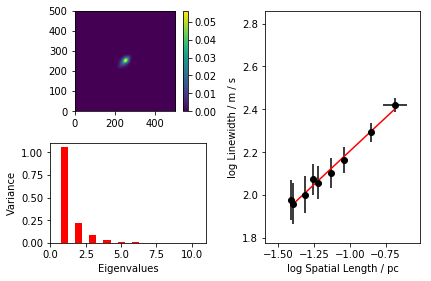

In [6]:
pca.run(verbose=True, min_eigval=1e-4, spatial_output_unit=u.pc,
        spectral_output_unit=u.m / u.s, brunt_beamcorrect=False)  

Note that we have specified the output units for the both the spectral and spatial units. By default, these would be kept in pixel units. The key properties are shown when verbose=True: a summary of the results with a plot of the covariance matrix (top left), the variance described by the principal components (bottom left) and the size-line width relation (right). The proportion of variance is the variance contained in the N eigenvalues kept. In this case, we consider all eigenvalues with values above 1e-4 to be important. index is the slope of the size-line width relation, and gamma is the the slope with a correction factor applied (see gamma). The sonic length is derived from the intercept of the size-line width relation using a default temperature of 10 K (see below on how to change this).

Since this data is simulated, this example does not account for a finite beam size. If it did, however, we would want to deconvolve the spatial widths with the beam. To see this effect, let us assume these data have a 20” circular beam:

Proportion of Variance kept: 0.9996934513444641
Index: 0.56 (0.53, 0.58)
Gamma: 0.40 (0.36, 0.45)
Sonic length: 9.205e-02 (8.207e-02, 1.020e-01) pc at 10.0 K


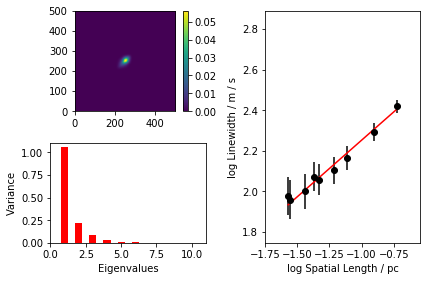

In [7]:
pca.run(verbose=True, min_eigval=1e-4, spatial_output_unit=u.pc,
        spectral_output_unit=u.m / u.s, brunt_beamcorrect=True, beam_fwhm=20 * u.arcsec)

Since the correction is not linear, the slope changes with the beam correction. If the header of the data has the beam information defined, it will be automatically read in and beam_fwhm will not have to be given.

Both of the PCA runs above do not subtract the mean of the data before creating the covariance matrix. Technically, this is not how PCA is defined (see Overview above) and the decomposition is not performed on a true covariance matrix. The justification used in Brunt, C. & Heyer, M. 2002a and Brunt, C. & Heyer, M. 2002b is that the mean has a physical meaning in this case: it’s the largest spatial scale across the map. If we do subtract the mean of, how does this affect the index?

Proportion of Variance kept: 0.9998085325029037
Index: 0.70 (0.67, 0.74)
Gamma: 0.63 (0.59, 0.66)
Sonic length: 1.004e-01 (9.384e-02, 1.070e-01) pc at 10.0 K


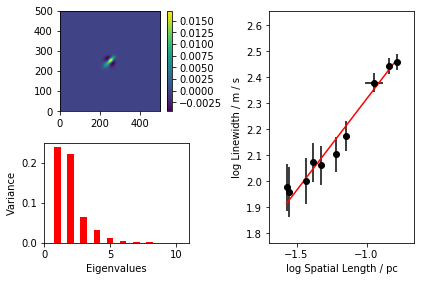

In [8]:
pca.run(verbose=True, min_eigval=1e-4, spatial_output_unit=u.pc,
        spectral_output_unit=u.m / u.s, brunt_beamcorrect=True, beam_fwhm=20 * u.arcsec, mean_sub=True)

The plot shows how the structure of the covariance matrix has changed. There remains a central peak, though it is smaller, and the positive structure around it is more elongated. The bar plot shows that the relative values of the eigenvalues have changed significantly; this intuitively makes sense as the covariance structure was changed. The index measured is significantly higher than the 0.56 measured above. If we compare the points on the size-line width relation, we see that the steeper relation results from the spectral width remaining the same as in the the non-mean subtracted case, while the spatial size is decreased.

The default setting is to not subtract the mean in order to best reproduce the established Brunt & Heyer formalism. This comparison is included to demonstrate its effect and to highlight that, in not subtracting the mean, some of the assumptions used in PCA are violated. See the PCA Wikipedia page for more information.

The run command has several steps hidden within it. To demonstrate the whole process, the individual steps are broken down below. There are 4 major steps: decomposition, spatial fitting, spectral fitting, and fitting of the size-line width relation.

First, the eigenvalue decomposition is performed using compute_pca:

In [10]:
pca.compute_pca(mean_sub=False, n_eigs='auto', min_eigval=1e-4, eigen_cut_method='value') 
pca.n_eigs

10

mean_sub controls whether to subtract the channel means when calculating the covariance matrix. Formally, this is implied when calculating any covariance matrix, but is not done in the Brunt & Heyer works (see above). n_eigs sets the number of important principal components (which will be used to fit the size-line width relation). This can be an integer, or the code will determine the number of important components based off of a threshold given in min_eigval. When eigen_cut_method='value', min_eigval is the smallest eigenvalue to consider important. Since the variance is related to the level of variance due to noise in the data, it is practical to set this to a few times the noise variance. When eigen_cut_method='proportion', min_eigval now corresponds to the total proportion of variance that is considered important:

In [12]:
pca.compute_pca(mean_sub=False, n_eigs='auto', min_eigval=0.99, eigen_cut_method='proportion')
pca.n_eigs

4

This will keep the number of components that describe 99% of the variance in the data. The percentage of variance described by a principal component is its eigenvalue divided by the sum of all eigenvalues (the total variance in the data). All other components beyond these levels are due to irreducible noise. These noise components can be thought of as an N-dimensional sphere, where it becomes impossible to diminish the remaining variance as there is no preferred direction.

Second, we calculate the spatial size scales from the autocorrelation of the eigenimages (reverting back to the PCs from eigen_cut_method='value'):

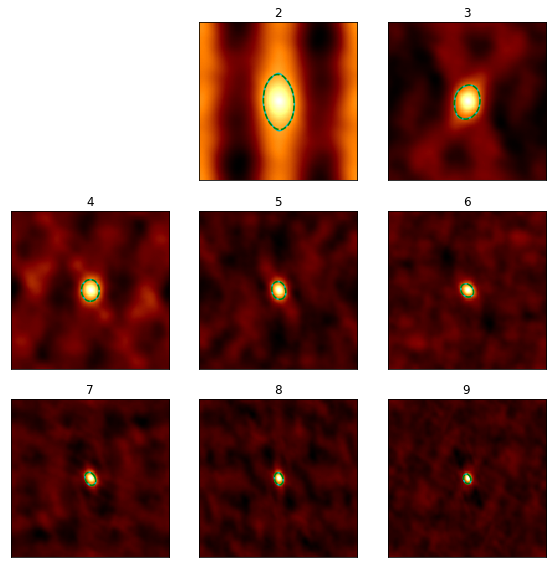

In [28]:
plt.figure(figsize=(8,8))
pca.compute_pca(mean_sub=False, n_eigs='auto', min_eigval=1e-4, eigen_cut_method='value')
pca.find_spatial_widths(method='contour', beam_fwhm=20 * u.arcsec, brunt_beamcorrect=True,
                        output_unit=u.pc, diagnosticplots=True)  

This will find the spatial widths by fitting an ellipse to the 1/e contour about the peak in the autocorrelation image, following the fitting technique described by Brunt & Heyer. The first 9 autocorrelation images are shown in the above image, where the cyan contours are the true 1/e contour, and the green dashed line is the elliptical fit. Note that the first autocorrelation image is not shown. This is because the fitting routine failed; if the 1/e level is not reached in the data, there is no contour to fit to. This means that the largest spatial scale in the data (which critically depends on the mean) is larger than the spatial size of the data. For a periodic-box simulation, which this example data is produced from, it is not surprising that this has occurred. Note: If this issue is encountered in observational data (or anything without periodic boundaries), try padding the data cube in the spatial directions with zeros to simulate a larger map size.

method may also be set to fit to fit a 2D Gaussian to the peak, interpolate which estimates the 1/e from the peak using a fine grid about the peak region, and xinterpolate which first fits a 2D Gaussian to better determine the fine grid to use in interpolation. The default method is contour.

When beam correction is applied (brunt_beamcorrect), the angular FWHM of the beam is needed. This is to deconvolve the spatial widths with the beam size. Note that all spatial scales that cannot be deconvolved from the beam will be set to NaN. If the BMAJ keyword is set in the FITS header in cube, this will be read automatically (also if the radio_beam package is installed, a few other keywords will be recognized). Otherwise, this must be specified in beam_fwhm. If the data do not have a beam size, brunt_beamcorrect=False will need to be specified in find_spatial_widths and run.

Third, we find the spectral widths:

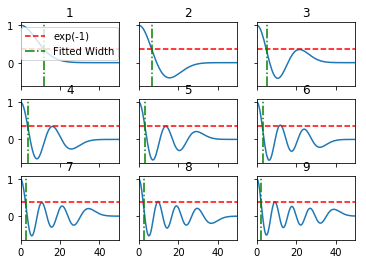

In [31]:
import numpy as np
pca.find_spectral_widths(method='walk-down', output_unit=u.m / u.s)  
autocorr_spec = pca.autocorr_spec()
x = np.fft.rfftfreq(500) * 500 / 2.0  
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True)  
for i, ax in zip(range(9), axes.ravel()):  
    ax.plot(x, autocorr_spec[:251, i])  
    ax.axhline(np.exp(-1), label='exp(-1)', color='r', linestyle='--')  
    ax.axvline(pca.spectral_width[i].value / pca._spectral_size.value, label='Fitted Width', color='g', linestyle='-.')  
    ax.set_title("{}".format(i + 1))  
    ax.set_xlim([0, 50])  
    if i == 0:  
         ax.legend()

The above image shows the 50 components of the first 9 autocorrelation spectra (the data cube has 500 channels in total, but this is the region of interest). The local minima referred to in the next paragraph is the first minimum point in each of the spectra.

There are three methods available to estimate spectral widths of the autocorrelation spectra. walk-down starts from the peak and continues until the 1/e level is reached. The width is estimated by averaging the points before and after this level is reached. This is the method used by Brunt & Heyer. Otherwise, method may be set to fit, which fits a Gaussian to the data before the fits local minima occurs, and interpolate, which does the same, but through interpolating onto a finer grid. As shown in the above figure, the number of oscillations in the autocorrelation spectrum increases with the Nth principal component. The width of interest is determined from the first peak to the first minima.

Note: If your input data has few spectral channels, it may be necessary to pad additional channels of zeros onto the data. Otherwise the 1/e level may not be reached. This should not have a significant effect on the results, as the added eigenvalues of these channels will be zero and should not be considered.

Finally, we fit the size-line width relation. There is no clear independent variable to fit, and significant errors in both dimensions which must be taken into account. This is the error-in-variables problem, and an excellent explanation is provided in Hogg, D, Bovy, J, & Lang D.. The Brunt & Heyer works have used the bisector method, which has several drawbacks. In TurbuStat, two fitting methods are available: Orthogonal Distance Regression (ODR), and a Markov Chain Monte Carlo (MCMC) method. Practically both methods are doing the same thing, but the MCMC provides a direct sampling (assuming uniform priors). The MCMC method requires the emcee package to be installed.

To run ODR:

Beta: [0.53911909 2.78471754]
Beta Std Error: [0.02723396 0.03154007]
Beta Covariance: [[0.00644967 0.00725125]
 [0.00725125 0.00865049]]
Residual Variance: 0.11499642023564308
Inverse Condition #: 0.11845686840197925
Reason(s) for Halting:
  Sum of squares convergence


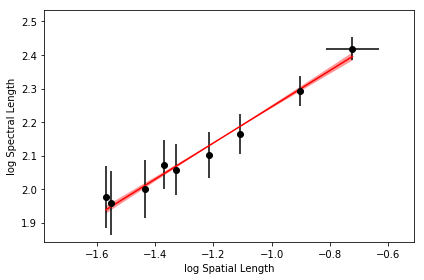

In [20]:
pca.fit_plaw(fit_method='odr', verbose=True)

Slope: 0.5620018866693673 (0.490569085795327, 0.6406766692448875)
Intercept: 2.8081096835266943 (2.7255086189043904, 2.9011807852178038)


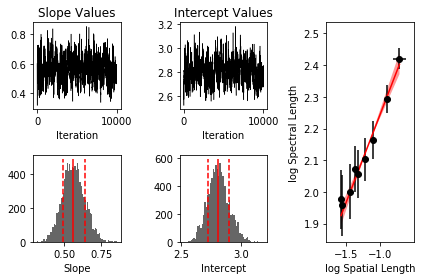

In [21]:
pca.fit_plaw(fit_method='bayes', verbose=True)

Additional arguments for setting the chain properties can be passed as well. See documentation for bayes_linear. The verbose mode shows the fit results along with the data points.

The interesting outputs from this analysis are estimates of the slopes of the size-line width relation (γ
) and the sonic length:

In [25]:
pca.gamma

0.41017268927011413

In [26]:
pca.sonic_length(T_k=10 * u.K, mu=1.36)

(<Quantity 0.09649063 pc>, <Quantity [0.05590453, 0.15508192] pc>)

Since the sonic length depends on temperature and μ
, this is a function and not a property like γ
. PCA.sonic_length also returns the 1-sigma error bounds. The error bounds in γ
 can be accessed with PCA.gamma_error_range.

Heyer, M., & Schloerb, P. 1997

Brunt, C. & Heyer, M. 2013

Brunt, C. & Heyer, M. 2002a

Brunt, C. & Heyer, M. 2002b

Hogg, D, Bovy, J, & Lang D.